# ATTENTION: this notebook has to be executed in `/forks/nn_breaking_detection/`

In [ ]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers.core import Lambda
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import keras
from utils import *

import tensorflow as tf
from setup_mnist import MNIST, MNISTModel
from setup_cifar import CIFAR, CIFARModel
import os

import sys
sys.path.append("..")
print(os.listdir("..") )
from fast_gradient_sign import FGS
from nn_robust_attacks.l2_attack import CarliniL2

%load_ext autoreload
%autoreload 2

In [2]:
class Wrap:
    def __init__(self, model):
        self.image_size = 28 if ISMNIST else 32
        self.num_channels = 1 if ISMNIST else 3
        self.num_labels = 10
        self.model = model

    def predict(self, xs):
        return self.model(xs)

def make_model(Model, dropout=True, fixed=False):
    def Dropout(p):
        if not dropout: 
            p = 0
        def my_dropout(x):
            if fixed:
                shape = x.get_shape().as_list()[1:]
                keep = np.random.random(shape)>p
                return x*keep
            else:
                return tf.nn.dropout(x, 1-p)
        return keras.layers.core.Lambda(my_dropout)

    return Model(None, Dropout=Dropout).model
    

def compute_u(sess, modeld, data, T):
    ys = np.array(list(zip(*[sess.run(tf.nn.softmax(modeld.predict(data))) for _ in range(T)])))
    print(ys.shape)
    
    term1 = np.mean(np.sum(ys**2,axis=2),axis=1)

    term2 = np.sum(np.mean(ys,axis=1)**2,axis=1)

    print('absolute mean uncertenty',np.mean(term1-term2))
    
    return term1-term2

In [3]:
# inspired by: https://github.com/lsgos/uncertainty-adversarial-paper/blob/master/src/utilities.py#L302-L332
def entropy(X):
    return np.sum(- X * np.log(np.clip(X, 1e-6, 1)), axis=-1)


def expected_entropy(X):
    """
    Take a tensor of MC predictions [#images x #MC x #classes] and return the
    mean entropy of the predictive distribution across the MC samples.
    """

    return np.mean(entropy(X), axis=-1)


def predictive_entropy(X):
    """
    Take a tensor of MC predictions [#images x #MC x #classes] and return the
    entropy of the mean predictive distribution across the MC samples.
    """
    return entropy(np.mean(X, axis=1))

def mutual_information(X):
    """
    Take a tensor of MC predictions [#images x #MC x #classes] and return the
    mutual information for each image
    """
    return predictive_entropy(X) - expected_entropy(X)

In [4]:
def compute_mi(sess, modeld, data, T):
    ys = np.array(list(zip(*[sess.run(tf.nn.softmax(modeld.predict(data))) for _ in range(T)])))
    print(ys.shape)
    
    mi = mutual_information(ys)

    print('absolute mean MI uncertenty',np.mean(mi))
    
    return mi

In [11]:
def test(Model, data, path):
    keras.backend.set_learning_phase(False)
    
    model = make_model(Model, dropout=False)
#     print(model.summary())
    model.load_weights(path)

    modeld = make_model(Model, dropout=True)
    modeld.load_weights(path)

    guess = model.predict(data.test_data)
    print('Accuracy wihtout dropout',np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels,axis=1)))

    guess = modeld.predict(data.test_data)
    print('Accuracy with dropout', np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels,axis=1)))
    
    sess = keras.backend.get_session()

    N = 10000
    labs = get_labs(data.test_data[:N])
#     print(labs)
    print('good?',np.sum(labs*data.test_labels[:N]))
    
    batch_size = 100 if N > 100 else N

    attack = CarliniL2(sess, Wrap(model), batch_size=batch_size, max_iterations=1000,
                       binary_search_steps=3, learning_rate=1e-1, initial_const=1,
                       targeted=True, confidence=0)
    adv = attack.attack(data.test_data[:N], labs)
    guess = model.predict(adv)
    print('average distortion',np.mean(np.sum((data.test_data[:N]-adv)**2,axis=(1,2,3))**.5))
#     print(guess[:10])
    print('Accuracy for adv', np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels[:N],axis=1)))

    T=30
    

    print("SV: Test data")
    sv_test = compute_u(sess, modeld, data.test_data[:N],T)
    print("SV: Adversarial examples")
    sv_adv = compute_u(sess, modeld, adv, T)
    
    print("MI: Test data")
    mi_test = compute_mi(sess, modeld, data.test_data[:N], T)
    print("MI: Adversarial examples")
    mi_adv = compute_mi(sess, modeld, adv, T)
    
    adv_labels = labs
    test_labels = data.test_labels[:N]
    
    data = (sv_test, sv_adv, mi_test, mi_adv, adv_labels, test_labels)
    
    return data

In [ ]:
ISMNIST=False
data = test(CIFARModel, CIFAR(), "models/cifar")

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

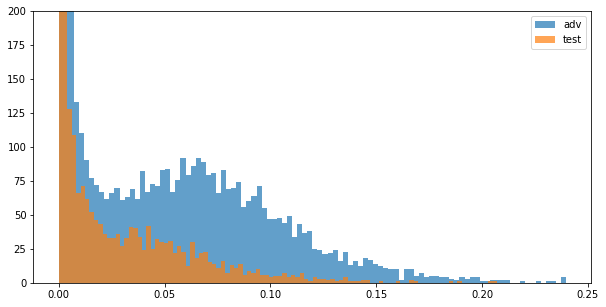

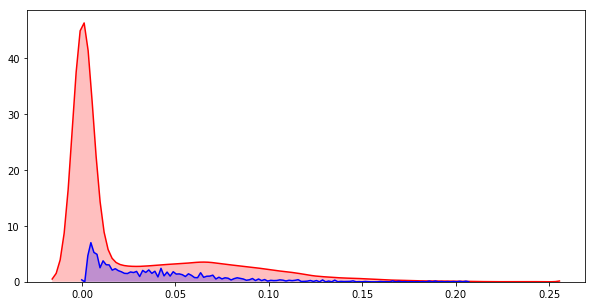

In [31]:
sv_test, sv_adv, mi_test, mi_adv, adv_labels, test_lables = data
plt.figure(figsize=(10,5))
plt.hist(mi_adv, bins=100, label='adv',alpha=0.7)
plt.hist(mi_test, bins=100, label= 'test', alpha=0.7)
plt.ylim(0,200)
plt.legend()
plt.figure(figsize=(10,5))
sns.kdeplot(mi_adv, shade=True, color="r")
sns.kdeplot(mi_test, shade=True, color="b")
plt.show()

In [27]:
from sklearn.metrics import roc_curve

def plot_roc(adv_list,real_list,names):
    """
    
    :param adv_list: list of detection measure values for adversarial inputs
    :param real_list: list of detection measure values for real inputs
    :param names: list of names for the measures
    :return: 
    """
    
    plt.figure(figsize=(10,10))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    for i, (adv,real) in enumerate(zip(adv_list,real_list)):
        adv_labels = [1] * len(adv)
        real_labels = [0] * len(real)
        labels = np.array(adv_labels + real_labels)
        samples = np.concatenate([adv, real])
        
        lw = 2
        fpr, tpr, _ = roc_curve(labels, samples, pos_label=1)
        plt.plot(fpr, tpr, lw=lw, label=names[i])
        plt.plot([0, 1], [0, 1], color='lightgray', lw=lw, linestyle='--')
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Detection Measure')
    plt.legend(loc="lower right")


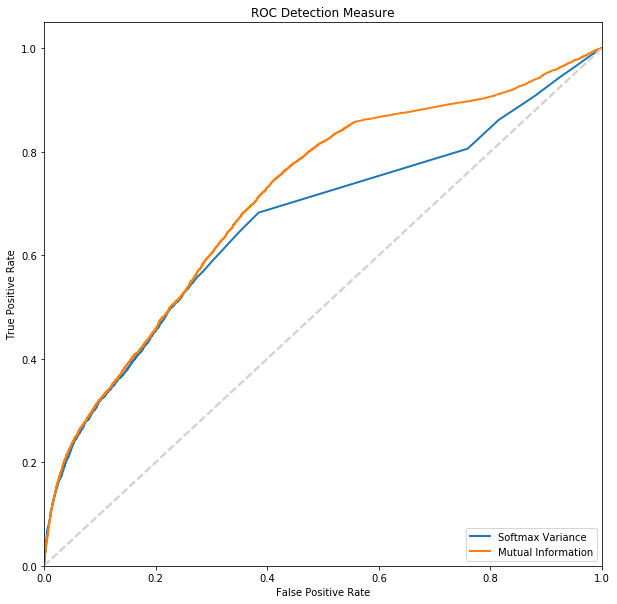

In [28]:
plot_roc([sv_adv, mi_adv], [sv_test, mi_test], ['Softmax Variance', 'Mutual Information'])